# Achieving goals more effectively and efficiently


* **Model-free RL**: Refers to algorithms that don't use models of the environments, but are still abe to preoduce a policy. The unique characteristic here is these methods obtain policies without the use of a map, a model, or an MDP. Instead, they use trial-and-error learning to obtain policies. Several examples of model-free RL algorithms are MC, SARSA, and Q-learning

* **Model-based RL**: Refers to algorithms that can learn, but don't require a model of the environment to produce a policy. The distinction is they don't require models in advance, but can certainly make good use of them if available, and more importantly, attempt to learn the models through interaction with the environment. Several examples of model-based RL are Dyna-Q and trajectory sampling



Sampling models vs. distributional models

* **Sampling models**: Refers to models of the environment that produce a single sample of how the environment will transition given some probabilities
* **Distributional models**: Refers to models of the environment that produce the probability distribution of the transition and reward functions


In [20]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.mplot3d import Axes3D

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [21]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [22]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [23]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [24]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [25]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [26]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q, 
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret
            
            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)
            
            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100, 
                        np.mean(episode_reward), 
                        np.mean(episode_regret)))
    return results

In [27]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [28]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=True, dtype=np.int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env, 
                gamma=gamma, 
                pi=lambda s: pi[s], 
                goal_state=goal_state, 
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma

In [29]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [30]:
def plot_transition_model(T_track, episode = 0):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=50)

    color_left = '#008fd5' # ax._get_lines.get_next_color()
    color_right = '#fc4f30' #ax._get_lines.get_next_color()

    left_prob = np.divide(T_track[episode][:,0].T, 
                          T_track[episode][:,0].sum(axis=1).T).T
    left_prob = np.nan_to_num(left_prob, 0)

    right_prob = np.divide(T_track[episode][:,1].T, 
                           T_track[episode][:,1].sum(axis=1).T).T
    right_prob = np.nan_to_num(right_prob, 0)

    for s in np.arange(9):
        ax.bar3d(s+0.1, np.arange(9)+0.1, np.zeros(9),
                 np.zeros(9)+0.3,
                 np.zeros(9)+0.3, 
                 left_prob[s], 
                 color=color_left, 
                 alpha=0.75,
                 shade=True)
        ax.bar3d(s+0.1, np.arange(9)+0.1, left_prob[s],
                 np.zeros(9)+0.3,
                 np.zeros(9)+0.3, 
                 right_prob[s], 
                 color=color_right, 
                 alpha=0.75,
                 shade=True)

    ax.tick_params(axis='x', which='major', pad=10)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)

    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xticks(np.arange(9))
    ax.set_yticks(np.arange(9))

    plt.title('SWS learned MDP after {} episodes'.format(episode+1))
    ax.set_xlabel('Initial\nstate', labelpad=75, rotation=0)
    ax.set_ylabel('Landing\nstate', labelpad=75, rotation=0)
    ax.set_zlabel('Transition\nprobabilities', labelpad=75, rotation=0)

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_left)
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_right)

    plt.legend((left_proxy, right_proxy), 
               ('Left', 'Right'), 
               bbox_to_anchor=(0.15, 0.9), 
               borderaxespad=0.)

    ax.dist = 12
    #plt.gcf().subplots_adjust(left=0.1, right=0.9)
    plt.tight_layout()

    plt.show()

In [31]:
def plot_model_state_sampling(planning, algo='Dyna-Q'):
    fig = plt.figure(figsize=(20,10))

    color_left = '#008fd5' # ax._get_lines.get_next_color()
    color_right = '#fc4f30' #ax._get_lines.get_next_color()

    for s in np.arange(9):
        actions = planning[np.where(planning[:,0]==s)[0], 1]
        left = len(actions[actions == 0])
        right = len(actions[actions == 1])
        plt.bar(s, right, 0.2, color=color_right)
        plt.bar(s, left, 0.2, color=color_left, bottom=right)


    plt.title('States samples from {}\nlearned model of SWS environment'.format(algo))
    plt.xticks(range(9))
    plt.xlabel('Initial states sampled', labelpad=20)
    plt.ylabel('Count', labelpad=50, rotation=0)

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_left)
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_right)

    plt.legend((left_proxy, right_proxy), 
               ('Left', 'Right'), 
               bbox_to_anchor=(0.99, 1.1), 
               borderaxespad=0.)

    #plt.gcf().subplots_adjust(left=0.1, right=0.9)
    plt.tight_layout()

    plt.show()

In [32]:
def plot_model_state_7(planning, algo='Dyna-Q'):
    fig = plt.figure(figsize=(20,10))

    color_left = '#008fd5' # ax._get_lines.get_next_color()
    color_right = '#fc4f30' #ax._get_lines.get_next_color()


    state_7 = planning[np.where(planning[:,0]==7)]
    for sp in [6, 7, 8]:

        actions = state_7[np.where(state_7[:,3]==sp)[0], 1]
        left = len(actions[actions == 0])
        right = len(actions[actions == 1])
        plt.bar(sp, right, 0.2, color=color_right)
        plt.bar(sp, left, 0.2, color=color_left, bottom=right)


    plt.title('Next states samples by {}\nin SWS environment from state 7'.format(algo))
    plt.xticks([6,7,8])
    plt.xlabel('Landing states', labelpad=20)
    plt.ylabel('Count', labelpad=50, rotation=0)

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_left)
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_right)

    plt.legend((left_proxy, right_proxy), 
               ('Left', 'Right'), 
               bbox_to_anchor=(0.99, 1.1), 
               borderaxespad=0.)

    #plt.gcf().subplots_adjust(left=0.1, right=0.9)
    plt.tight_layout()

    plt.show()

In [33]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

## Slippery Walk Seven

In [34]:
%%capture
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
gamma = 0.99
n_episodes = 3000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', '>')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

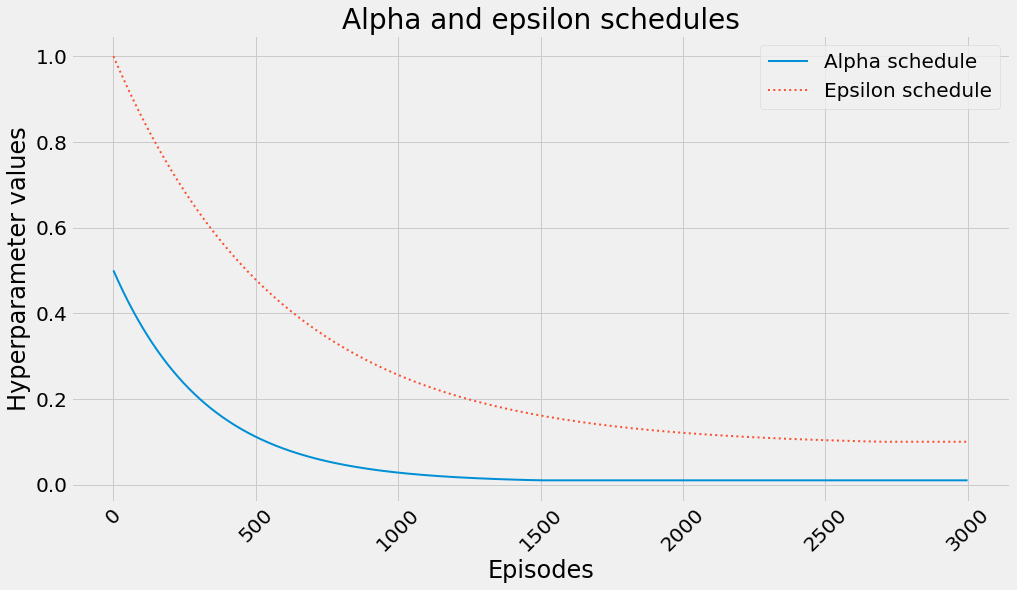

In [35]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

In [36]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╕
│   s │     < │     > │
╞═════╪═══════╪═══════╡
│   0 │ 0     │ 0     │
├─────┼───────┼───────┤
│   1 │ 0.312 │ 0.564 │
├─────┼───────┼───────┤
│   2 │ 0.67  │ 0.763 │
├─────┼───────┼───────┤
│   3 │ 0.803 │ 0.845 │
├─────┼───────┼───────┤
│   4 │ 0.864 │ 0.889 │
├─────┼───────┼───────┤
│   5 │ 0.901 │ 0.922 │
├─────┼───────┼───────┤
│   6 │ 0.932 │ 0.952 │
├─────┼───────┼───────┤
│   7 │ 0.961 │ 0.981 │
├─────┼───────┼───────┤
│   8 │ 0     │ 0     │
╘═════╧═══════╧═══════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.8672. Regret of 0.0000


## SARSA($\lambda$): Improving policies after each step based on multi-step estimates

SARSA($\lambda$) is a straightforward improvement to the original SARSA agent. The main difference between SARSA and SARSA($\lambda$) is that instead of using the one-step bootstrapping target- the *TD* target, it uses the $\lambda$-return

In [37]:
def sarsa_lambda(env,
                gamma=1.0,
                init_alpha=0.5,
                min_alpha=0.01,
                alpha_decay_ratio=0.5,
                init_epsilon=1.0,
                min_epsilon=0.1,
                epsilon_decay_ratio=0.9,
                lambda_=0.5,
                replacing_traces=True,
                n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    # elegibility traces to keep track
    # of states eligible for updates
    E = np.zeros((nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
                np.argmax(Q[state]) \
                if np.random.random() > epsilon \
                else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )
    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio, n_episodes
    )


    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            E[state][action] = E[state][action] + 1

            if replacing_traces:
                E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible
            # state-action pairs at once
            Q = Q + alphas[e] * td_error * E
            E = gamma * lambda_ * E # decay the elegibilities
            state, action = next_state, next_action
        
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

    return Q, V, pi, Q_track, pi_track

### SARSA($\lambda$) replacing

In [38]:
%%capture
Q_rsls, V_rsls, Q_track_rsls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rsl, V_rsl, pi_rsl, Q_track_rsl, pi_track_rsl = sarsa_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rsls.append(Q_rsl) ; V_rsls.append(V_rsl) ; Q_track_rsls.append(Q_track_rsl)
Q_rsl, V_rsl, Q_track_rsl = np.mean(Q_rsls, axis=0), np.mean(V_rsls, axis=0), np.mean(Q_track_rsls, axis=0)
del Q_rsls ; del V_rsls ; del Q_track_rsls

In [39]:
print_state_value_function(V_rsl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rsl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rsl, optimal_V)))
print()
print_action_value_function(Q_rsl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rsl, optimal_Q)))
print()
print_policy(pi_rsl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rsl, mean_return_rsl, mean_regret_rsl = get_policy_metrics(
    env, gamma=gamma, pi=pi_rsl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rsl, mean_return_rsl, mean_regret_rsl))

State-value function found by Sarsa(λ) replacing:
|           | 01  0.456 | 02 0.6997 | 03 0.8045 | 04 0.8647 | 05 0.9087 | 06 0.9457 | 07 0.9789 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.11 | 02  -0.06 | 03  -0.04 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0448

Sarsa(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.189 │ 0.456 │ 0.312 │ 0.564 │   0.123 │   0.108 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.507 │ 0.7   │ 0.67  │ 0.763 │   0.163 │   0.063 │
├───

### SARSA($\lambda$) accumulating

In [40]:
%%capture
Q_asls, V_asls, Q_track_asls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_asl, V_asl, pi_asl, Q_track_asl, pi_track_asl = sarsa_lambda(env, gamma=gamma, 
                                                                   replacing_traces=False, 
                                                                   n_episodes=n_episodes)
    Q_asls.append(Q_asl) ; V_asls.append(V_asl) ; Q_track_asls.append(Q_track_asl)
Q_asl, V_asl, Q_track_asl = np.mean(Q_asls, axis=0), np.mean(V_asls, axis=0), np.mean(Q_track_asls, axis=0)
del Q_asls ; del V_asls ; del Q_track_asls

In [41]:
print_state_value_function(V_asl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_asl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_asl, optimal_V)))
print()
print_action_value_function(Q_asl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_asl, optimal_Q)))
print()
print_policy(pi_asl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_asl, mean_return_asl, mean_regret_asl = get_policy_metrics(
    env, gamma=gamma, pi=pi_asl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_asl, mean_return_asl, mean_regret_asl))

State-value function found by Sarsa(λ) accumulating:
|           | 01 0.5083 | 02 0.7235 | 03 0.8132 | 04 0.8713 | 05 0.9115 | 06 0.9457 | 07 0.9785 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.06 | 02  -0.04 | 03  -0.03 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0261

Sarsa(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.211 │ 0.508 │ 0.312 │ 0.564 │   0.101 │   0.055 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.53  │ 0.724 │ 0.67  │ 0.763 │   0.14  │   0.039 

## Watkins's Q($\lambda$): Decoupling behavior from learning, again

The off-policy control version of the $\lambda$ algorithms. $Q(\lambda)$ is an extension of Q-learning that uses $\lambda$-return for policy-evaluation requirements of the generalized policy-iteration pattern.

In [42]:
def q_lambda(env,
                gamma=1.0,
                init_alpha=0.5,
                min_alpha=0.01,
                alpha_decay_ratio=0.5,
                init_epsilon=1.0,
                min_epsilon=0.1,
                epsilon_decay_ratio=0.9,
                lambda_=0.5,
                replacing_traces=True,
                n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    E = np.zeros((nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )
    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio, n_episodes
    )

    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])

            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]

            if replacing_traces:
                E[state].fill(0)

            E[state][action] = E[state][action] + 1
            Q = Q + alphas[e] * td_error * E

            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                E.fill(0)
            
            state, action = next_state, next_action
        
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

    return Q, V, pi, Q_track, pi_track

### Q($\lambda$) replacing

In [43]:
%%capture
Q_rqlls, V_rqlls, Q_track_rqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rqll, V_rqll, pi_rqll, Q_track_rqll, pi_track_rqll = q_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rqlls.append(Q_rqll) ; V_rqlls.append(V_rqll) ; Q_track_rqlls.append(Q_track_rqll)
Q_rqll, V_rqll, Q_track_rqll = np.mean(Q_rqlls, axis=0), np.mean(V_rqlls, axis=0), np.mean(Q_track_rqlls, axis=0)
del Q_rqlls ; del V_rqlls ; del Q_track_rqlls

In [44]:
print_state_value_function(V_rqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rqll, optimal_V)))
print()
print_action_value_function(Q_rqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rqll, optimal_Q)))
print()
print_policy(pi_rqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rqll, mean_return_rqll, mean_regret_rqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_rqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rqll, mean_return_rqll, mean_regret_rqll))

State-value function found by Q(λ) replacing:
|           | 01 0.5562 | 02 0.7542 | 03 0.8409 | 04 0.8882 | 05 0.9214 | 06 0.9511 | 07  0.981 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.01 | 02  -0.01 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06   -0.0 | 07    0.0 |           |
State-value function RMSE: 0.0041

Q(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.291 │ 0.556 │ 0.312 │ 0.564 │   0.021 │   0.008 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.666 │ 0.754 │ 0.67  │ 0.763 │   0.004 │   0.009 │
├─────┼─────

### Q($\lambda$) accumulating

In [45]:
%%capture
Q_aqlls, V_aqlls, Q_track_aqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_aqll, V_aqll, pi_aqll, Q_track_aqll, pi_track_aqll = q_lambda(env, gamma=gamma, 
                                                                    replacing_traces=False,
                                                                    n_episodes=n_episodes)
    Q_aqlls.append(Q_aqll) ; V_aqlls.append(V_aqll) ; Q_track_aqlls.append(Q_track_aqll)
Q_aqll, V_aqll, Q_track_aqll = np.mean(Q_aqlls, axis=0), np.mean(V_aqlls, axis=0), np.mean(Q_track_aqlls, axis=0)
del Q_aqlls ; del V_aqlls ; del Q_track_aqlls

In [46]:
print_state_value_function(V_aqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_aqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_aqll, optimal_V)))
print()
print_action_value_function(Q_aqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_aqll, optimal_Q)))
print()
print_policy(pi_aqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_aqll, mean_return_aqll, mean_regret_aqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_aqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_aqll, mean_return_aqll, mean_regret_aqll))

State-value function found by Q(λ) accumulating:
|           | 01   0.53 | 02 0.7491 | 03 0.8409 | 04 0.8879 | 05 0.9206 | 06 0.9513 | 07 0.9803 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.03 | 02  -0.01 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06   -0.0 | 07   -0.0 |           |
State-value function RMSE: 0.0123

Q(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.287 │ 0.53  │ 0.312 │ 0.564 │   0.025 │   0.034 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.654 │ 0.749 │ 0.67  │ 0.763 │   0.016 │   0.014 │
├─────

## Dyna-Q: Learning sample models

In [47]:
def dyna_q(env,
            gamma=1.0,
            init_alpha=0.5,
            min_alpha=0.01,
            alpha_decay_ratio=0.5,
            init_epsilon=1.0,
            min_epsilon=0.1,
            epsilon_decay_ratio=0.9,
            n_planning=3,
            n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track, T_track, R_track, planning_track = [], [], [], []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    # To keep track of the transition function
    T_count = np.zeros((nS, nA, nS), dtype=np.float64)
    # To keep track of the reward signal
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )
    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio, n_episodes
    )

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False

        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)

            # increment the transition count
            T_count[state][action][next_state] += 1

            # Calculate an incremental mean of the reward signal
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += \
                    (r_diff / T_count[state][action][next_state])
            
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            backup_next_state = next_state

            # Planning step (simulates more iterations
            # using the learnt transition and reward
            # functions)
            for _ in range(n_planning):
                # make sure there have been updates
                # to the Q-function before
                if Q.sum() == 0: break

                # get list of all states that have been visited
                visited_states = np.where(np.sum(T_count, axis=(1,2)) > 0)[0]
                # select a random, previously visted state
                state = np.random.choice(visited_states)

                # list of all actions taken in prev state
                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                # select a random action
                action = np.random.choice(actions_taken)

                # get prob distribution of next_state given (state, action)
                probs = T_count[state][action] / T_count[state][action].sum()
                # select a random next_state with prev prob. distribution
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                # get predicted reward
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                # update the Q-function using the simulated
                # experience
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error

            state = backup_next_state
        
        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track, T_track, R_track, np.array(planning_track)


In [48]:
%%capture
Q_dqs, V_dqs, Q_track_dqs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(
        env, gamma=gamma, n_episodes=n_episodes)
    Q_dqs.append(Q_dq) ; V_dqs.append(V_dq) ; Q_track_dqs.append(Q_track_dq)
Q_dq, V_dq, Q_track_dq = np.mean(Q_dqs, axis=0), np.mean(V_dqs, axis=0), np.mean(Q_track_dqs, axis=0)
del Q_dqs ; del V_dqs ; del Q_track_dqs

In [49]:
print_state_value_function(V_dq, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dq, mean_return_dq, mean_regret_dq = get_policy_metrics(
    env, gamma=gamma, pi=pi_dq, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dq, mean_return_dq, mean_regret_dq))

State-value function found by Dyna-Q:
|           | 01  0.565 | 02 0.7576 | 03 0.8433 | 04 0.8861 | 05 0.9205 | 06 0.9507 | 07 0.9816 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01    0.0 | 02  -0.01 | 03   -0.0 | 04   -0.0 | 05   -0.0 | 06   -0.0 | 07    0.0 |           |
State-value function RMSE: 0.0023

Dyna-Q action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.303 │ 0.565 │ 0.312 │ 0.564 │   0.009 │  -0.001 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.671 │ 0.758 │ 0.67  │ 0.763 │  -0     │   0.005 │
├─────┼───────┼───────┼─────

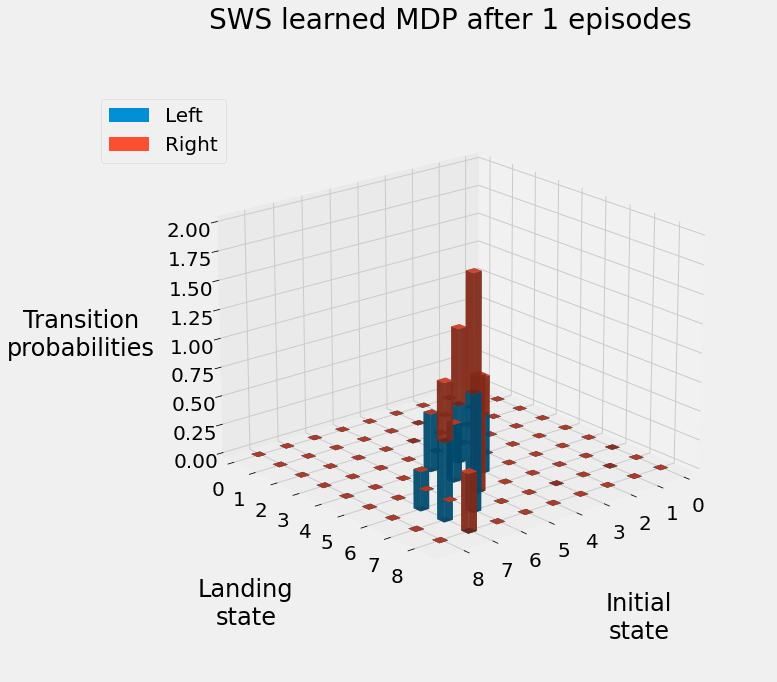

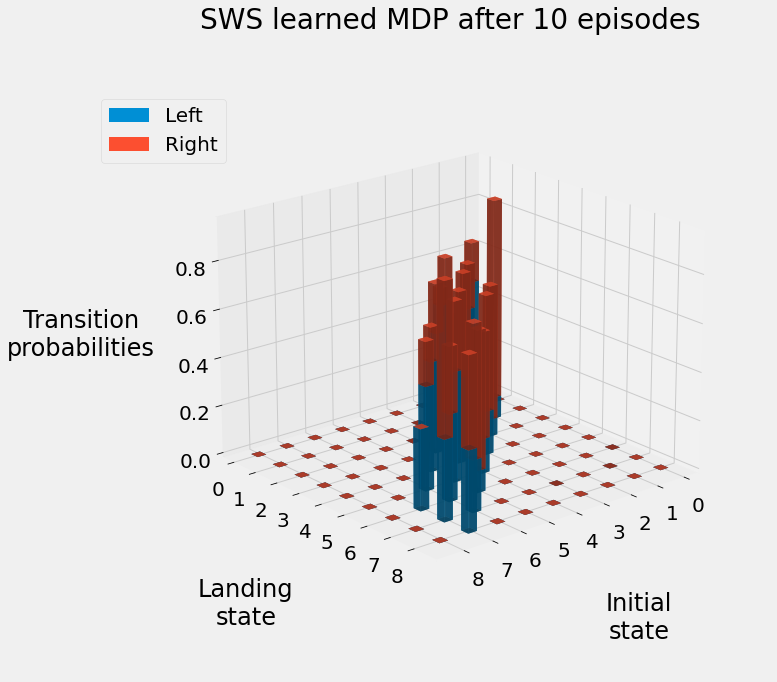

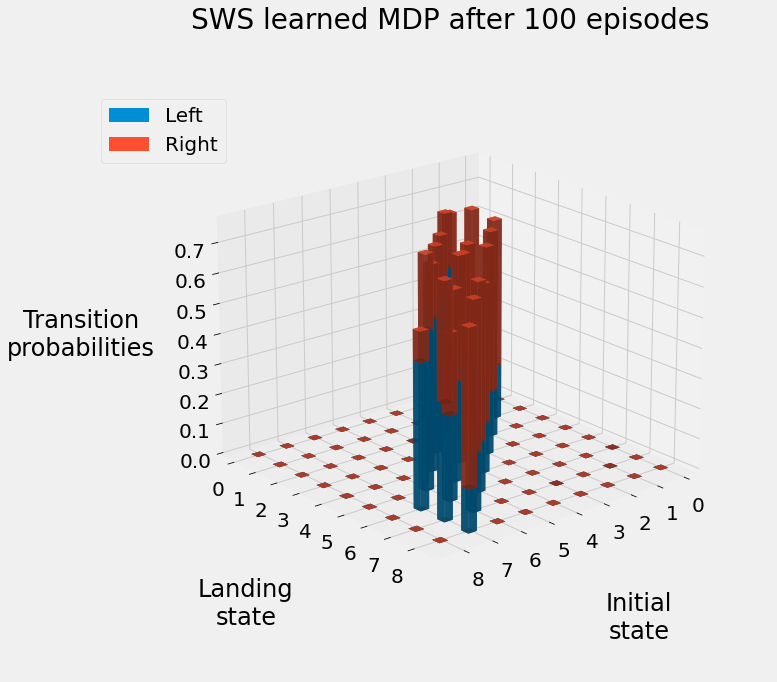

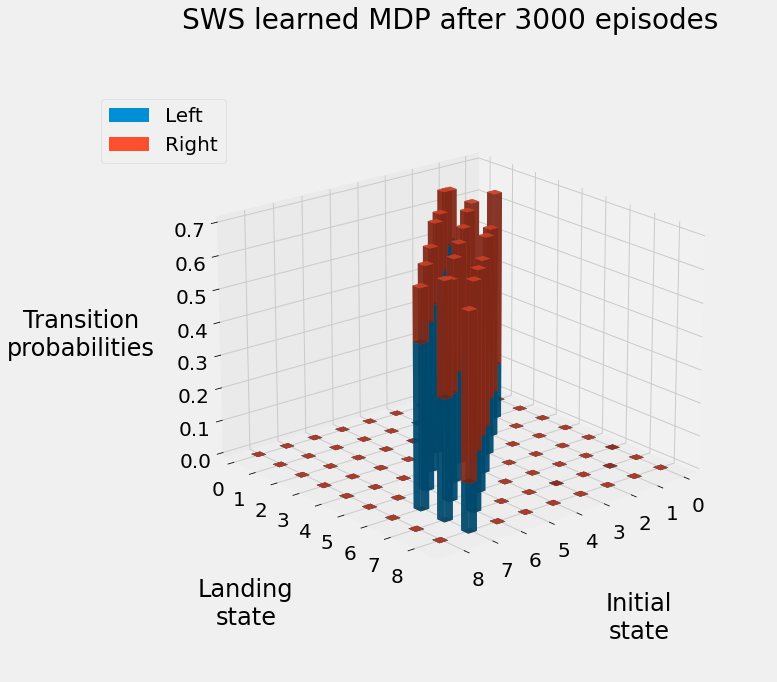

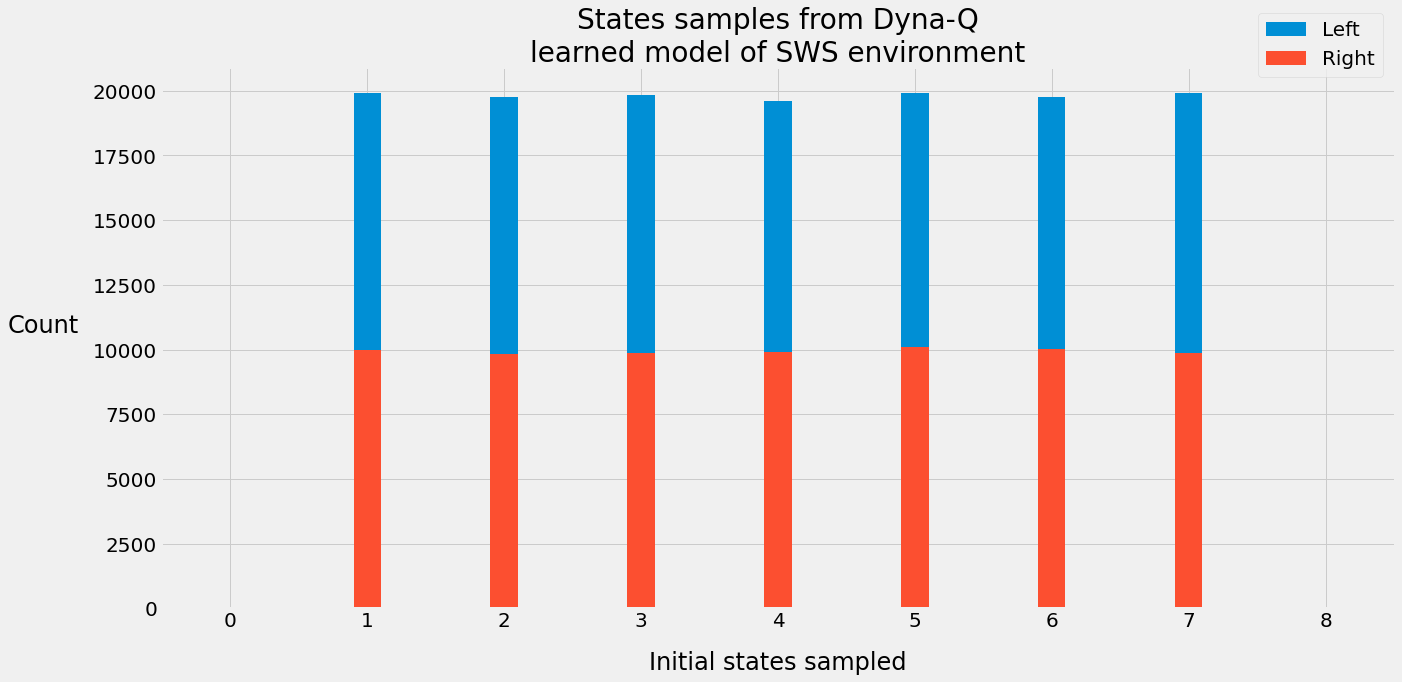

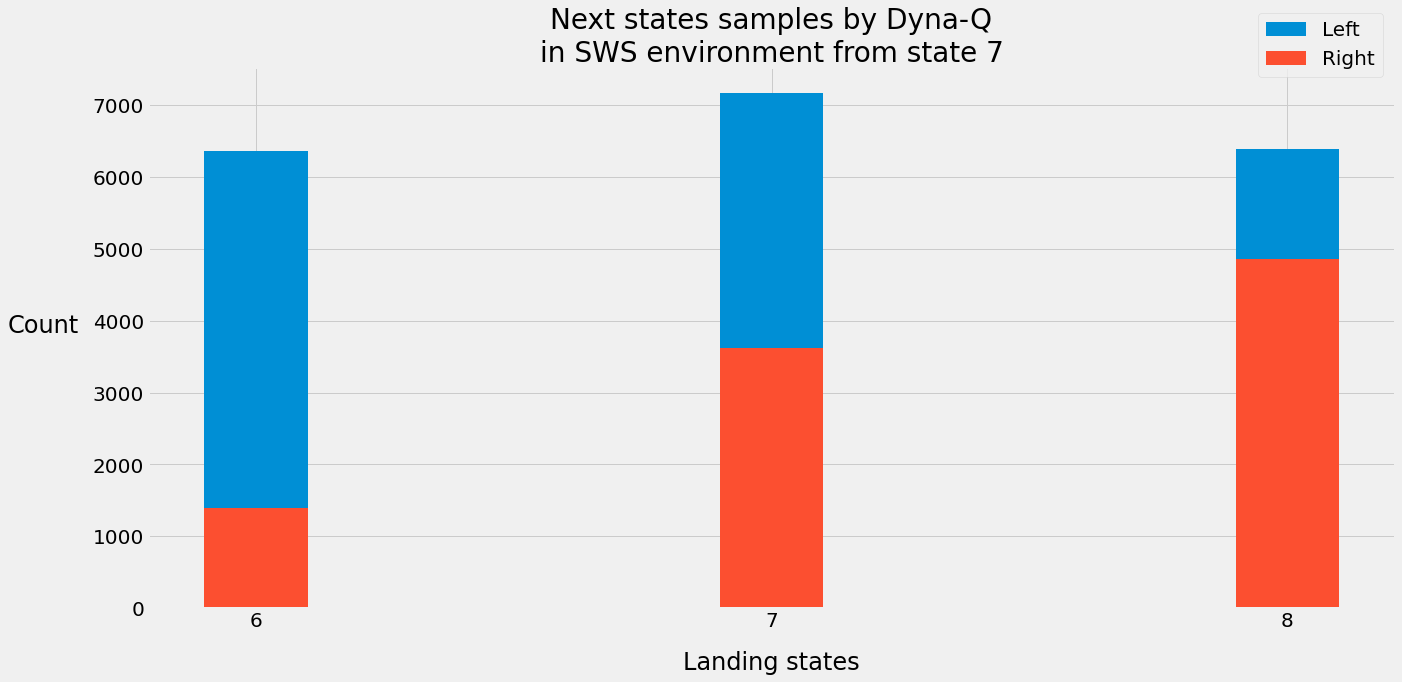

In [50]:
# %matplotlib qt
plot_transition_model(T_track_dq, episode=0)
plot_transition_model(T_track_dq, episode=9)
plot_transition_model(T_track_dq, episode=99)
plot_transition_model(T_track_dq, episode=len(T_track_dq)-1)
plot_model_state_sampling(planning_dq, algo='Dyna-Q')
plot_model_state_7(planning_dq, algo='Dyna-Q')

## Trajectory sampling: Making plans for the immediate future

Similar to Dyna-Q but instead of selecting random actions in the planning steps, it either on-policy or off-policy (greedy policy) to select the action.

In [53]:
def trajectory_sampling(env,
                        gamma=1.0,
                        init_alpha=0.5,
                        min_alpha=0.01,
                        alpha_decay_ratio=0.5,
                        init_epsilon=1.0,
                        min_epsilon=0.1,
                        epsilon_decay_ratio=0.9,
                        max_trajectory_depth=100,
                        planning_freq=5,
                        greedy_planning=True,
                        n_episodes=3000):

    # most of the algo is very similar to 
    # Dyna-Q
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track, T_track, R_track, planning_track = [], [], [], []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    T_count = np.zeros((nS, nA, nS), dtype=np.int)
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
                    np.argmax(Q[state]) \
                    if np.random.random() > epsilon \
                    else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )
    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio, n_episodes
    )

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False

        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)

            T_count[state][action][next_state] += 1
            
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += \
                    (r_diff / T_count[state][action][next_state])

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            backup_next_state = next_state

            # until here, it is the same as Dyna-Q
            # Here the planning steps starts
            if e % planning_freq == 0:
                for _ in range(max_trajectory_depth):
                    # check that the Q-function 
                    # has any difference
                    if Q.sum() == 0: break

                    # select the action either on-policy 
                    # or off-policy (using the greedy policy)
                    action = Q[state].argmax() if greedy_planning else \
                                    select_action(state, Q, epsilons[e])

                    # check that the transition has 
                    # been previously experienced
                    if not T_count[state][action].sum(): break

                    probs = T_count[state][action] / T_count[state][action].sum()
                    next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                    reward = R_model[state][action][next_state]

                    planning_track.append((state, action, reward, next_state))

                    # update the Q-function as if with real experience
                    td_target = reward + gamma * Q[next_state].max()
                    td_error = td_target - Q[state][action]
                    Q[state][action] = Q[state][action] + alphas[e] * td_error

                    state = next_state
            
            state = backup_next_state
        
        T_track.append(T_count.copy())
        R_track.append(R_model.copy())

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

    return Q, V, pi, Q_track, pi_track, T_track, R_track, np.array(planning_track)

In [54]:
%%capture
Q_tss, V_tss, Q_track_tss = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ts, V_ts, pi_ts, Q_track_ts, pi_track_ts, T_track_ts, R_track_ts, planning_ts = trajectory_sampling(
        env, gamma=gamma, n_episodes=n_episodes)
    Q_tss.append(Q_ts) ; V_tss.append(V_ts) ; Q_track_tss.append(Q_track_ts)
Q_ts, V_ts, Q_track_ts = np.mean(Q_tss, axis=0), np.mean(V_tss, axis=0), np.mean(Q_track_tss, axis=0)
del Q_tss ; del V_tss ; del Q_track_tss

In [55]:
print_state_value_function(V_ts, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Trajectory Sampling:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ts - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ts, optimal_V)))
print()
print_action_value_function(Q_ts, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Trajectory Sampling action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ts, optimal_Q)))
print()
print_policy(pi_ts, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ts, mean_return_ts, mean_regret_ts = get_policy_metrics(
    env, gamma=gamma, pi=pi_ts, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ts, mean_return_ts, mean_regret_ts))

State-value function found by Trajectory Sampling:
|           | 01 0.5509 | 02 0.7578 | 03 0.8424 | 04 0.8873 | 05 0.9226 | 06 0.9522 | 07 0.9811 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.01 | 02  -0.01 | 03   -0.0 | 04   -0.0 | 05    0.0 | 06    0.0 | 07    0.0 |           |
State-value function RMSE: 0.0048

Trajectory Sampling action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.299 │ 0.551 │ 0.312 │ 0.564 │   0.013 │   0.013 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.671 │ 0.758 │ 0.67  │ 0.763 │  -0     │   0.005 │
├─

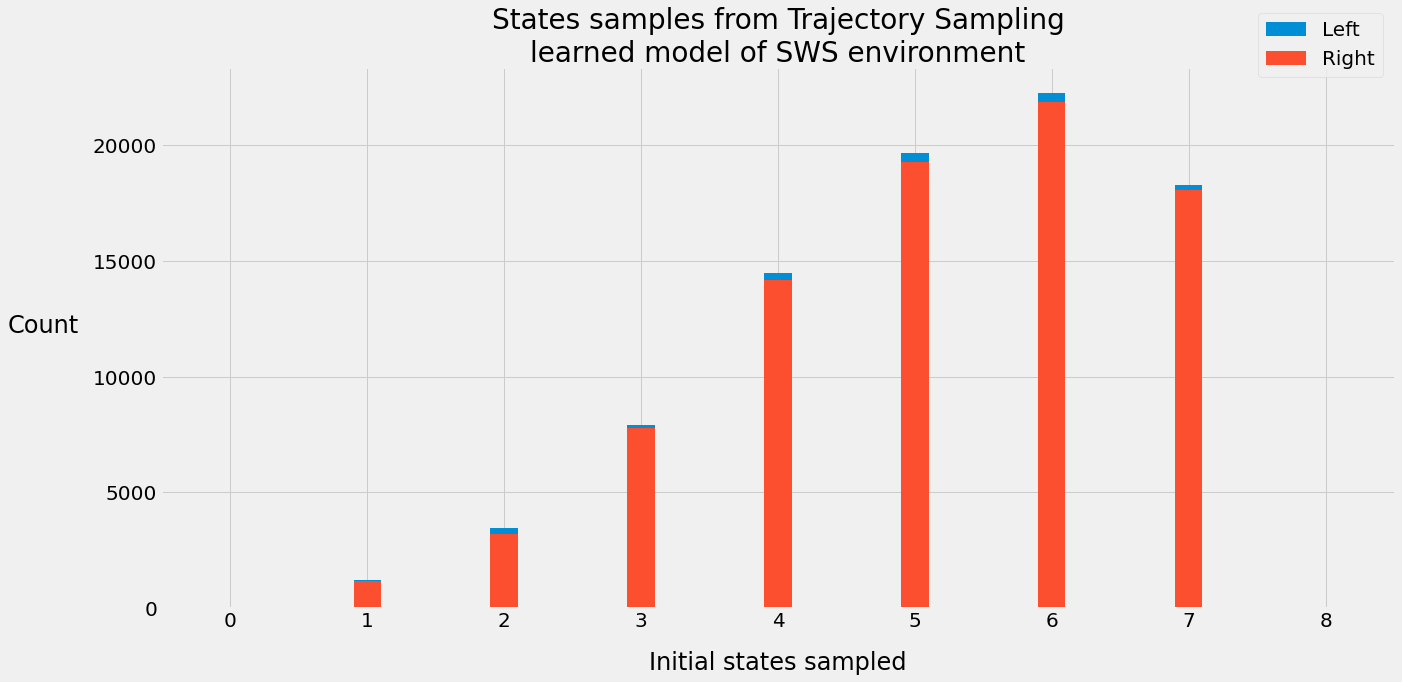

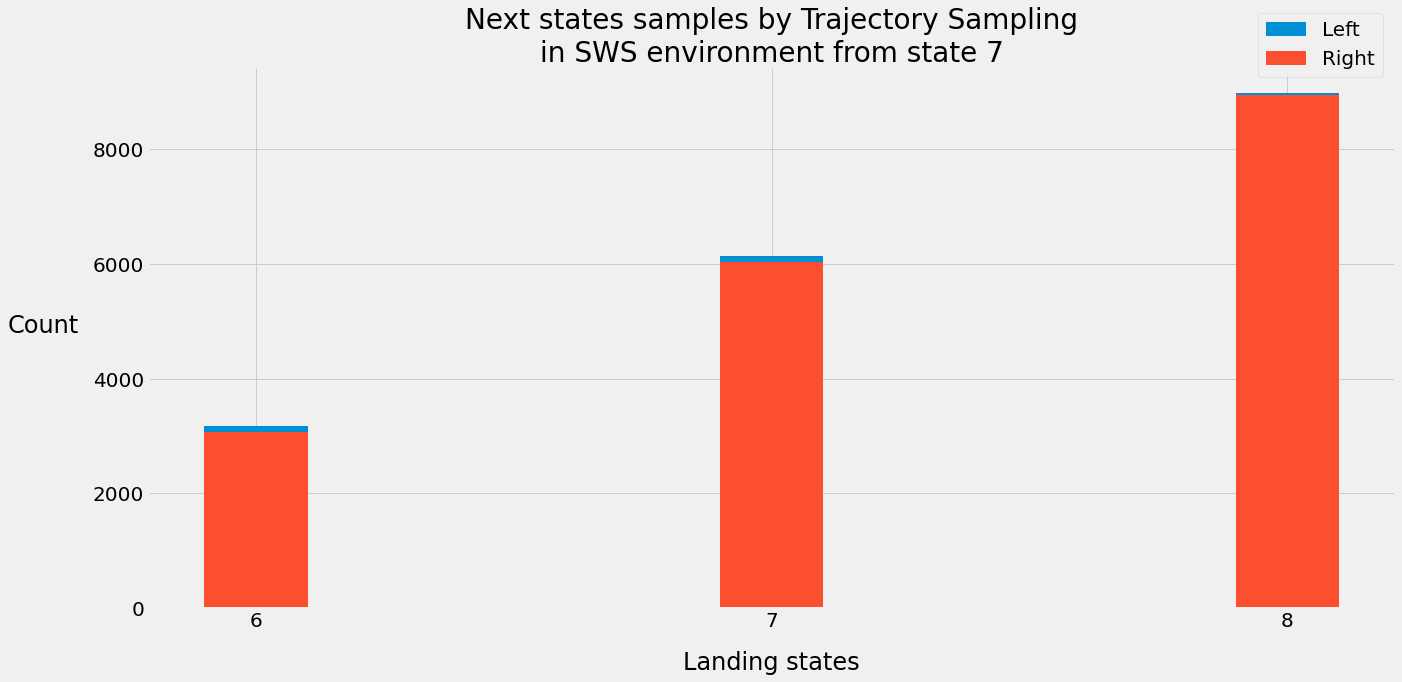

In [56]:
plot_model_state_sampling(planning_ts, algo='Trajectory Sampling')
plot_model_state_7(planning_ts, algo='Trajectory Sampling')

## Comparison of max(Q) for every episode

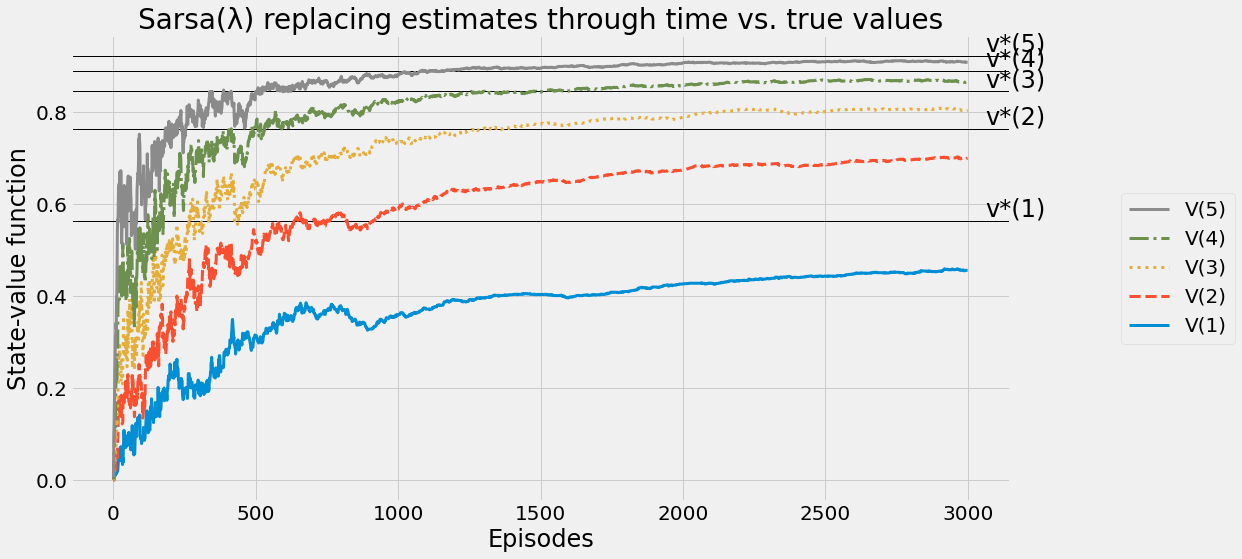

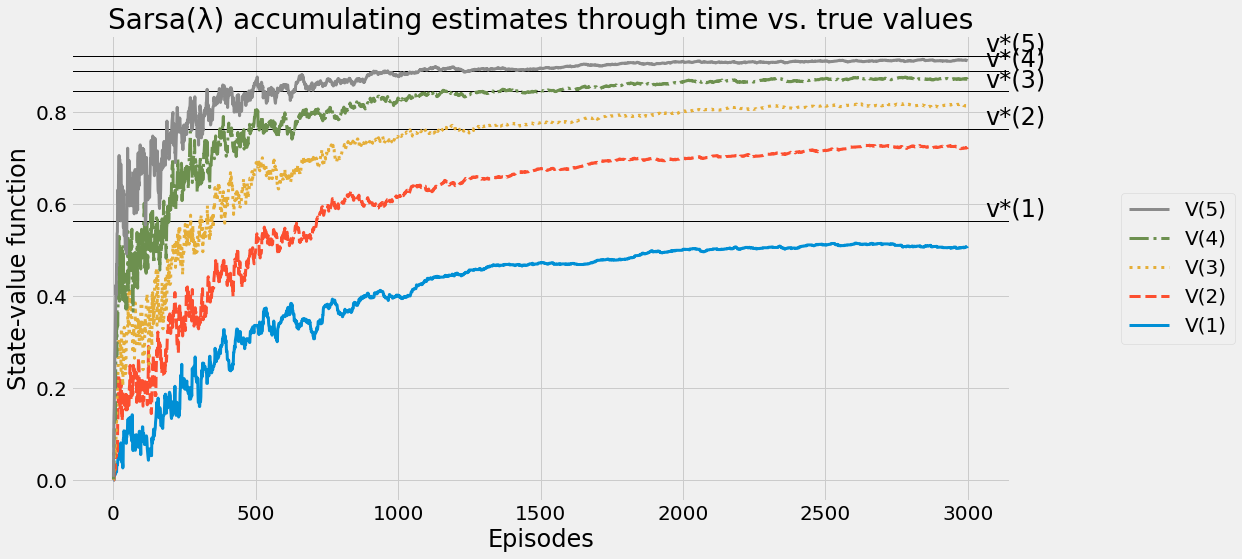

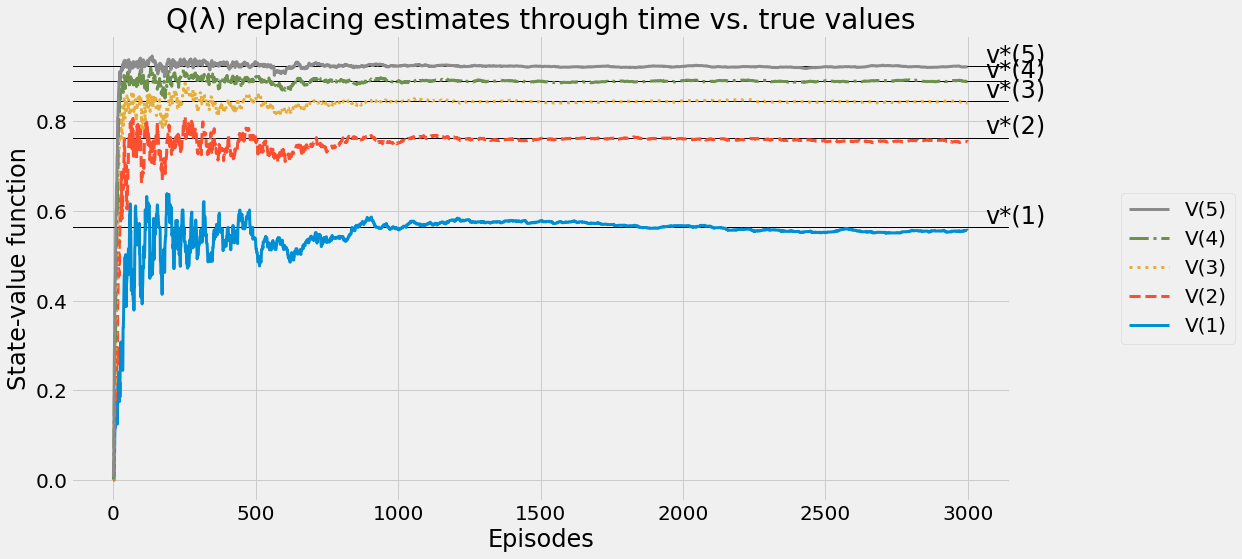

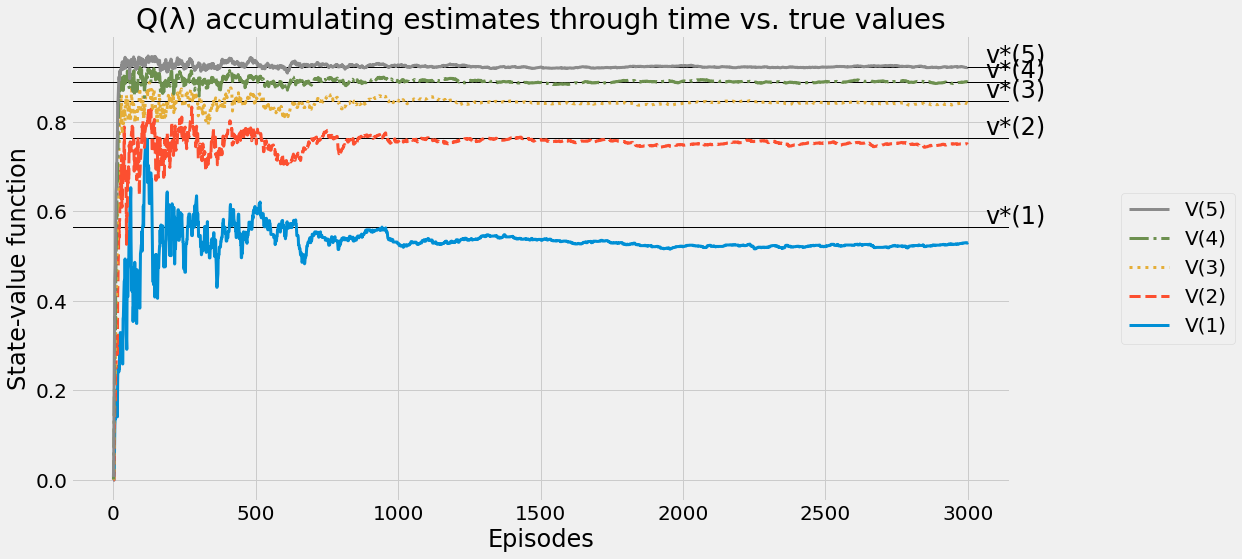

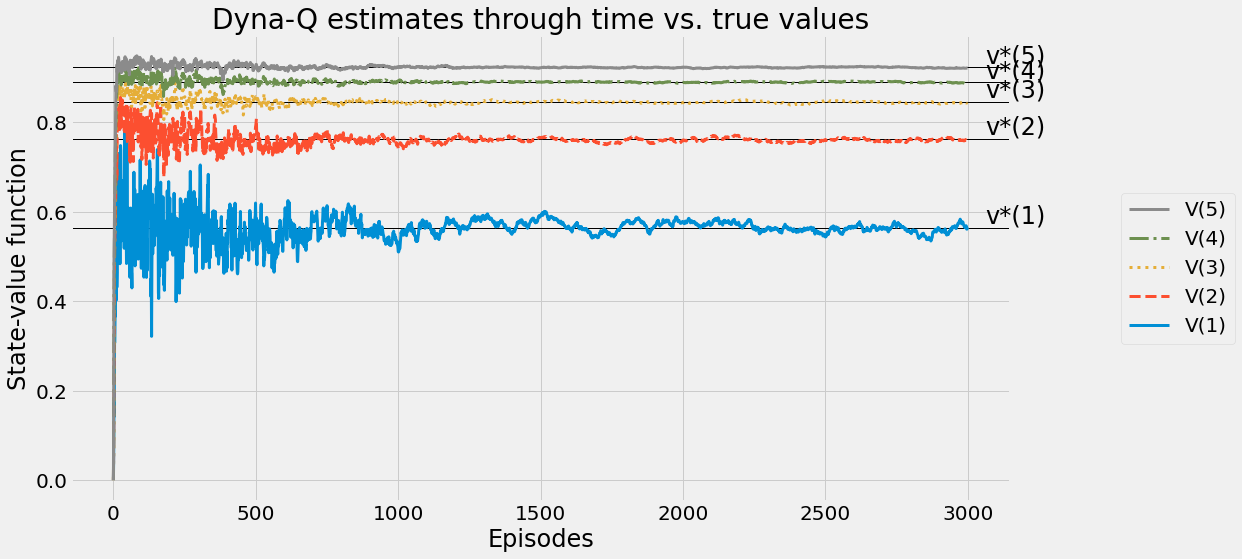

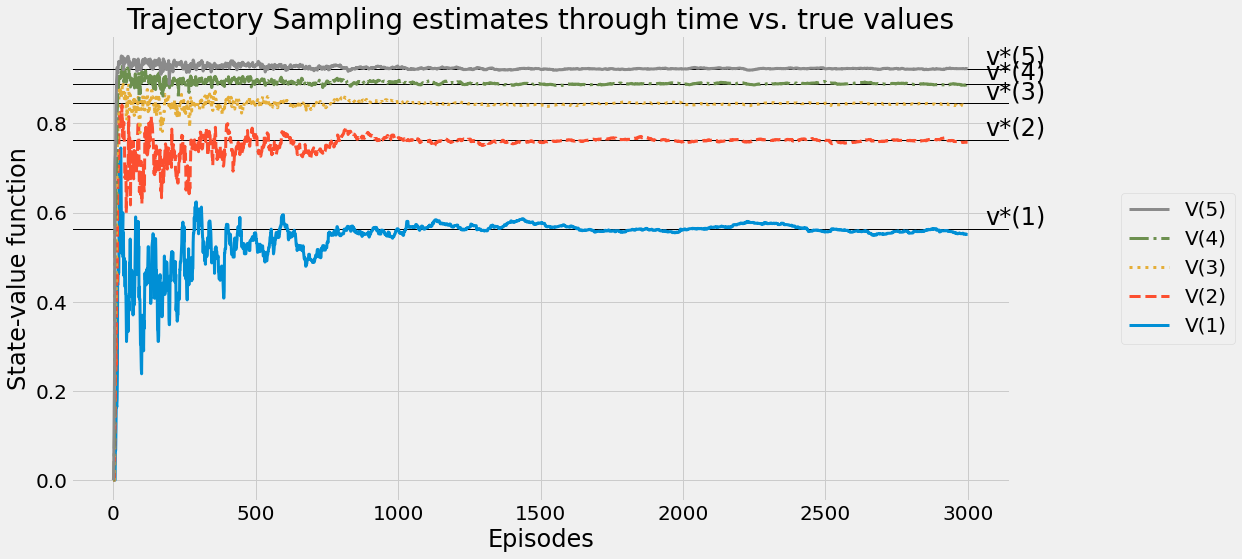

In [57]:
plot_value_function(
    'Sarsa(λ) replacing estimates through time vs. true values', 
    np.max(Q_track_rsl, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Sarsa(λ) accumulating estimates through time vs. true values', 
    np.max(Q_track_asl, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Q(λ) replacing estimates through time vs. true values', 
    np.max(Q_track_rqll, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Q(λ) accumulating estimates through time vs. true values', 
    np.max(Q_track_aqll, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Trajectory Sampling estimates through time vs. true values', 
    np.max(Q_track_ts, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

## FrozenLake Environment

In [59]:
env = gym.make('FrozenLake-v1')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 10000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=4, 4, 2, 3
action_symbols=('<', 'v', '>', '^')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.01, 2000

### Alpha and Epsilon schedules

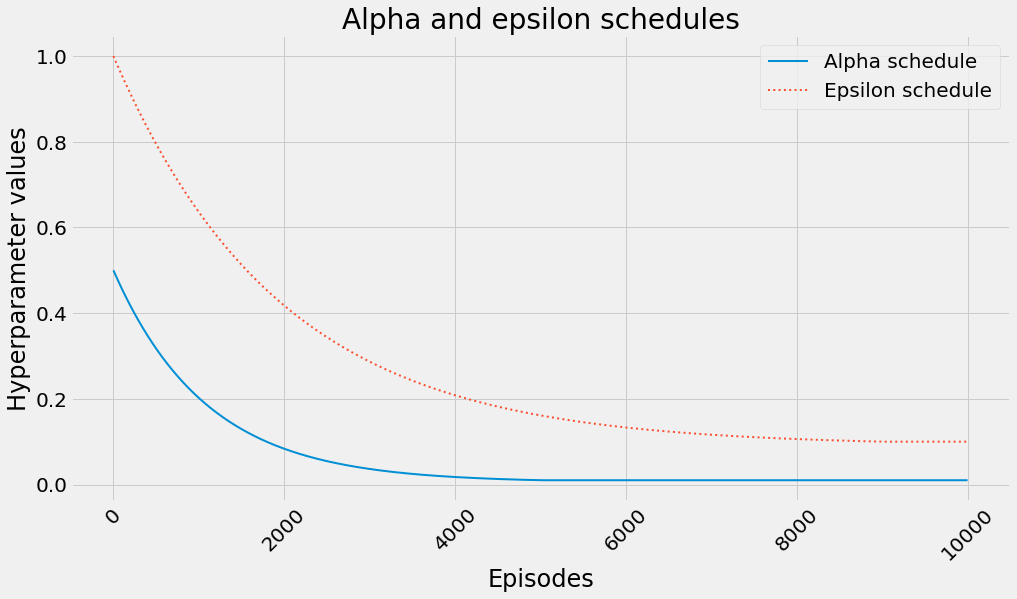

In [60]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

### Optimal value functions and policy

In [61]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╕
│   s │     < │     v │     > │     ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│   0 │ 0.542 │ 0.528 │ 0.528 │ 0.522 │
├─────┼───────┼───────┼───────┼───────┤
│   1 │ 0.343 │ 0.334 │ 0.32  │ 0.499 │
├─────┼───────┼───────┼───────┼───────┤
│   2 │ 0.438 │ 0.434 │ 0.424 │ 0.471 │
├─────┼───────┼───────┼───────┼───────┤
│   3 │ 0.306 │ 0.306 │ 0.302 │ 0.457 │
├─────┼───────┼───────┼───────┼───────┤
│   4 │ 0.558 │ 0.38  │ 0.374 │ 0.363 │
├─────┼───────┼───────┼───────┼───────┤
│   5 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│   6 │ 0.358 │ 0.203 │ 0.358 │ 0.155 │
├─────┼───────┼───────┼───────┼───────┤
│   7 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───

### SARSA lambda with replacing traces

In [62]:
%%capture
Q_rsls, V_rsls, Q_track_rsls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rsl, V_rsl, pi_rsl, Q_track_rsl, pi_track_rsl = sarsa_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rsls.append(Q_rsl) ; V_rsls.append(V_rsl) ; Q_track_rsls.append(Q_track_rsl)
Q_rsl, V_rsl, Q_track_rsl = np.mean(Q_rsls, axis=0), np.mean(V_rsls, axis=0), np.mean(Q_track_rsls, axis=0)
del Q_rsls ; del V_rsls ; del Q_track_rsls

In [63]:
print_state_value_function(V_rsl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rsl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rsl, optimal_V)))
print()
print_action_value_function(Q_rsl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rsl, optimal_Q)))
print()
print_policy(pi_rsl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rsl, mean_return_rsl, mean_regret_rsl = get_policy_metrics(
    env, gamma=gamma, pi=pi_rsl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rsl, mean_return_rsl, mean_regret_rsl))

State-value function found by Sarsa(λ) replacing:
| 00 0.2911 | 01 0.2467 | 02 0.2201 | 03 0.1318 |
| 04 0.3114 |           | 06 0.2158 |           |
| 08 0.3608 | 09 0.4491 | 10 0.4588 |           |
|           | 13 0.5845 | 14 0.7745 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.25 | 01  -0.25 | 02  -0.25 | 03  -0.33 |
| 04  -0.25 |           | 06  -0.14 |           |
| 08  -0.23 | 09  -0.19 | 10  -0.16 |           |
|           | 13  -0.16 | 14  -0.09 |           |
State-value function RMSE: 0.181

Sarsa(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │  

### SARSA lambda with accumulating traces

In [64]:
%%capture
Q_asls, V_asls, Q_track_asls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_asl, V_asl, pi_asl, Q_track_asl, pi_track_asl = sarsa_lambda(env, gamma=gamma, 
                                                                   replacing_traces=False, 
                                                                   n_episodes=n_episodes)
    Q_asls.append(Q_asl) ; V_asls.append(V_asl) ; Q_track_asls.append(Q_track_asl)
Q_asl, V_asl, Q_track_asl = np.mean(Q_asls, axis=0), np.mean(V_asls, axis=0), np.mean(Q_track_asls, axis=0)
del Q_asls ; del V_asls ; del Q_track_asls

In [65]:
print_state_value_function(V_asl, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Sarsa(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_asl - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_asl, optimal_V)))
print()
print_action_value_function(Q_asl, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Sarsa(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_asl, optimal_Q)))
print()
print_policy(pi_asl, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_asl, mean_return_asl, mean_regret_asl = get_policy_metrics(
    env, gamma=gamma, pi=pi_asl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_asl, mean_return_asl, mean_regret_asl))

State-value function found by Sarsa(λ) accumulating:
| 00 0.2905 | 01  0.245 | 02 0.2237 | 03 0.1554 |
| 04 0.3134 |           | 06 0.2222 |           |
| 08 0.3617 | 09 0.4642 | 10 0.4841 |           |
|           | 13 0.5973 | 14 0.7758 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.25 | 01  -0.25 | 02  -0.25 | 03   -0.3 |
| 04  -0.25 |           | 06  -0.14 |           |
| 08  -0.23 | 09  -0.18 | 10  -0.13 |           |
|           | 13  -0.14 | 14  -0.09 |           |
State-value function RMSE: 0.1748

Sarsa(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   er

### Watkin's Q lambda with replacing traces

In [66]:
%%capture
Q_rqlls, V_rqlls, Q_track_rqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_rqll, V_rqll, pi_rqll, Q_track_rqll, pi_track_rqll = q_lambda(env, gamma=gamma, n_episodes=n_episodes)
    Q_rqlls.append(Q_rqll) ; V_rqlls.append(V_rqll) ; Q_track_rqlls.append(Q_track_rqll)
Q_rqll, V_rqll, Q_track_rqll = np.mean(Q_rqlls, axis=0), np.mean(V_rqlls, axis=0), np.mean(Q_track_rqlls, axis=0)
del Q_rqlls ; del V_rqlls ; del Q_track_rqlls

In [67]:
print_state_value_function(V_rqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) replacing:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_rqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_rqll, optimal_V)))
print()
print_action_value_function(Q_rqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) replacing action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_rqll, optimal_Q)))
print()
print_policy(pi_rqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_rqll, mean_return_rqll, mean_regret_rqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_rqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_rqll, mean_return_rqll, mean_regret_rqll))

State-value function found by Q(λ) replacing:
| 00 0.5248 | 01 0.4795 | 02 0.4526 | 03 0.4369 |
| 04 0.5411 |           | 06 0.3446 |           |
| 08 0.5757 | 09 0.6286 | 10 0.5975 |           |
|           | 13 0.7326 | 14 0.8548 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.02 | 01  -0.02 | 02  -0.02 | 03  -0.02 |
| 04  -0.02 |           | 06  -0.01 |           |
| 08  -0.02 | 09  -0.01 | 10  -0.02 |           |
|           | 13  -0.01 | 14  -0.01 |           |
State-value function RMSE: 0.0133

Q(λ) replacing action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ 

### Watkin's Q lambda with accumulating traces

In [68]:
%%capture
Q_aqlls, V_aqlls, Q_track_aqlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_aqll, V_aqll, pi_aqll, Q_track_aqll, pi_track_aqll = q_lambda(env, gamma=gamma, 
                                                                    replacing_traces=False,
                                                                    n_episodes=n_episodes)
    Q_aqlls.append(Q_aqll) ; V_aqlls.append(V_aqll) ; Q_track_aqlls.append(Q_track_aqll)
Q_aqll, V_aqll, Q_track_aqll = np.mean(Q_aqlls, axis=0), np.mean(V_aqlls, axis=0), np.mean(Q_track_aqlls, axis=0)
del Q_aqlls ; del V_aqlls ; del Q_track_aqlls

In [69]:
print_state_value_function(V_aqll, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q(λ) accumulating:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_aqll - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_aqll, optimal_V)))
print()
print_action_value_function(Q_aqll, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q(λ) accumulating action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_aqll, optimal_Q)))
print()
print_policy(pi_aqll, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_aqll, mean_return_aqll, mean_regret_aqll = get_policy_metrics(
    env, gamma=gamma, pi=pi_aqll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_aqll, mean_return_aqll, mean_regret_aqll))

State-value function found by Q(λ) accumulating:
| 00 0.5211 | 01 0.4763 | 02 0.4495 | 03 0.4351 |
| 04 0.5372 |           | 06 0.3635 |           |
| 08 0.5699 | 09  0.624 | 10 0.6008 |           |
|           | 13 0.7225 | 14 0.8489 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.02 | 01  -0.02 | 02  -0.02 | 03  -0.02 |
| 04  -0.02 |           | 06   0.01 |           |
| 08  -0.02 | 09  -0.02 | 10  -0.01 |           |
|           | 13  -0.02 | 14  -0.01 |           |
State-value function RMSE: 0.0157

Q(λ) accumulating action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   

### Dyna-Q

In [70]:
%%capture
Q_dqs, V_dqs, Q_track_dqs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(
        env, gamma=gamma, n_episodes=n_episodes)
    Q_dqs.append(Q_dq) ; V_dqs.append(V_dq) ; Q_track_dqs.append(Q_track_dq)
Q_dq, V_dq, Q_track_dq = np.mean(Q_dqs, axis=0), np.mean(V_dqs, axis=0), np.mean(Q_track_dqs, axis=0)
del Q_dqs ; del V_dqs ; del Q_track_dqs

In [71]:
print_state_value_function(V_dq, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dq, mean_return_dq, mean_regret_dq = get_policy_metrics(
    env, gamma=gamma, pi=pi_dq, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dq, mean_return_dq, mean_regret_dq))

State-value function found by Dyna-Q:
| 00 0.5371 | 01 0.4953 | 02 0.4672 | 03 0.4525 |
| 04 0.5552 |           | 06 0.3571 |           |
| 08 0.5901 | 09 0.6387 | 10  0.605 |           |
|           | 13 0.7319 | 14 0.8503 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00   -0.0 | 01   -0.0 | 02   -0.0 | 03   -0.0 |
| 04   -0.0 |           | 06   -0.0 |           |
| 08   -0.0 | 09   -0.0 | 10  -0.01 |           |
|           | 13  -0.01 | 14  -0.01 |           |
State-value function RMSE: 0.0054

Dyna-Q action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════

### Trajectory Sampling

In [72]:
%%capture
Q_tss, V_tss, Q_track_tss = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ts, V_ts, pi_ts, Q_track_ts, pi_track_ts, T_track_ts, R_track_ts, planning_ts = trajectory_sampling(
        env, gamma=gamma, n_episodes=n_episodes)
    Q_tss.append(Q_ts) ; V_tss.append(V_ts) ; Q_track_tss.append(Q_track_ts)
Q_ts, V_ts, Q_track_ts = np.mean(Q_tss, axis=0), np.mean(V_tss, axis=0), np.mean(Q_track_tss, axis=0)
del Q_tss ; del V_tss ; del Q_track_tss

In [73]:
print_state_value_function(V_ts, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Trajectory Sampling:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ts - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ts, optimal_V)))
print()
print_action_value_function(Q_ts, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Trajectory Sampling action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ts, optimal_Q)))
print()
print_policy(pi_ts, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ts, mean_return_ts, mean_regret_ts = get_policy_metrics(
    env, gamma=gamma, pi=pi_ts, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ts, mean_return_ts, mean_regret_ts))

State-value function found by Trajectory Sampling:
| 00 0.5409 | 01 0.5008 | 02 0.4701 | 03 0.4547 |
| 04 0.5548 |           | 06 0.3585 |           |
| 08 0.5884 | 09 0.6421 | 10 0.6049 |           |
|           | 13 0.7454 | 14 0.8706 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00   -0.0 | 01    0.0 | 02   -0.0 | 03   -0.0 |
| 04   -0.0 |           | 06    0.0 |           |
| 08   -0.0 | 09   -0.0 | 10  -0.01 |           |
|           | 13    0.0 | 14   0.01 |           |
State-value function RMSE: 0.0037

Trajectory Sampling action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > 

### Comparison of max(Q) for every episode

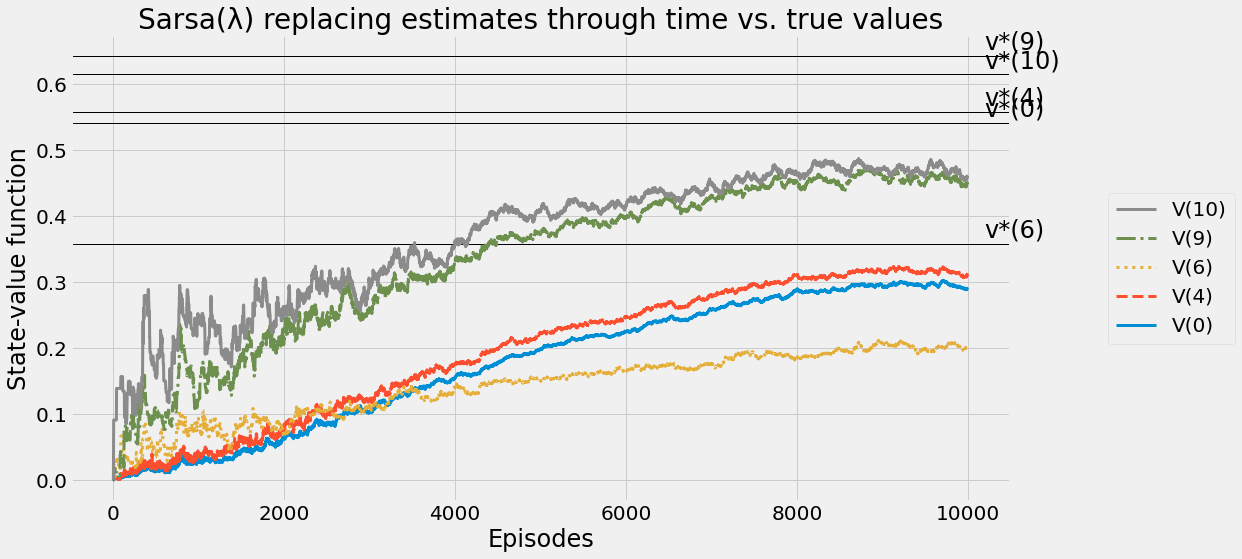

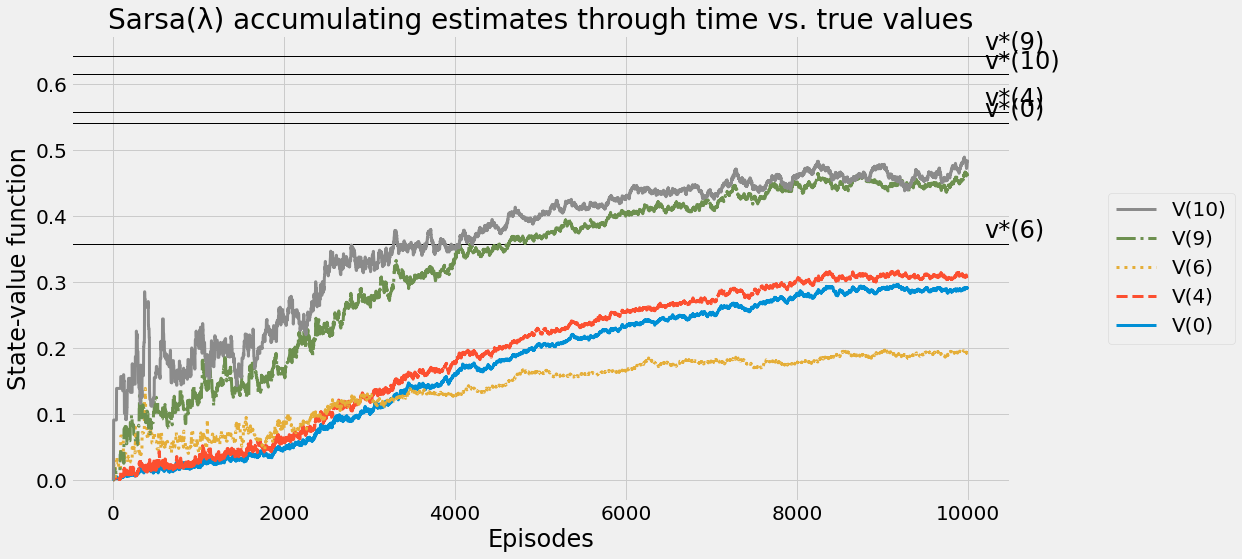

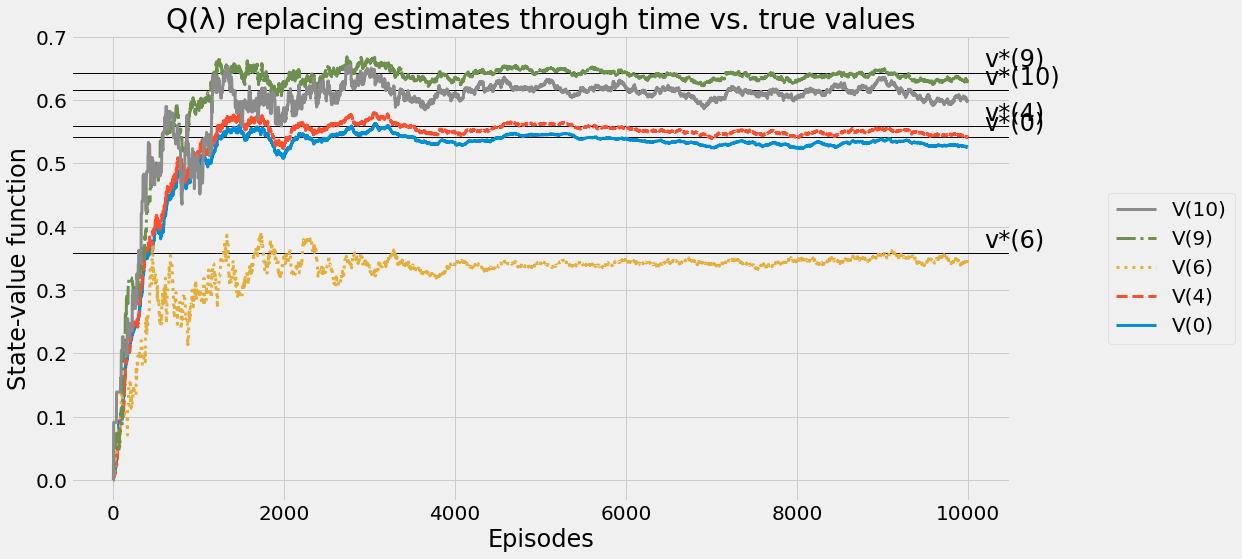

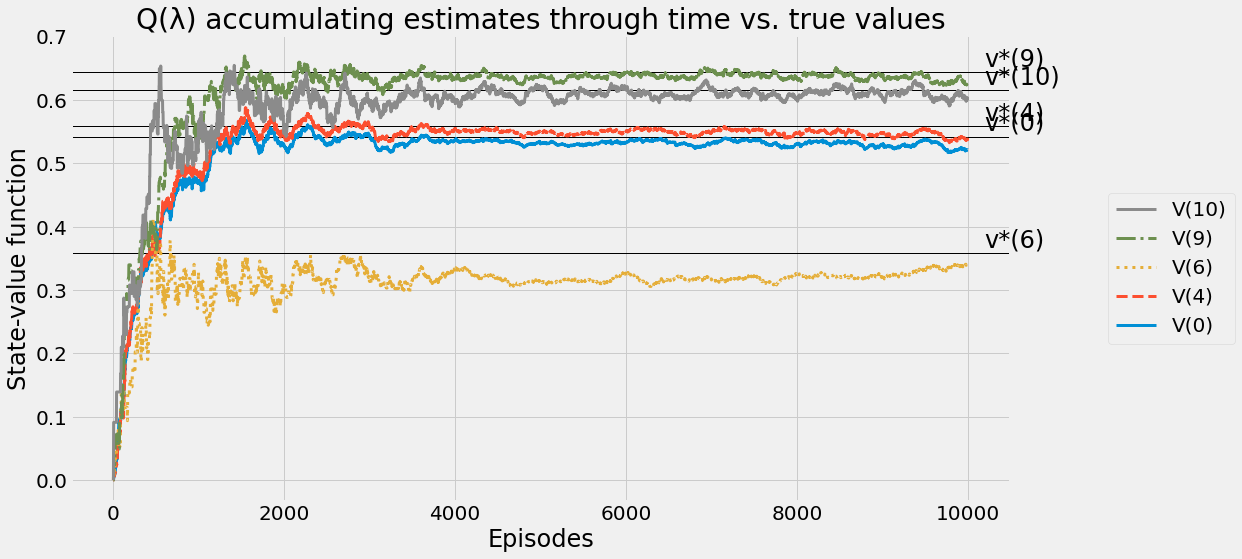

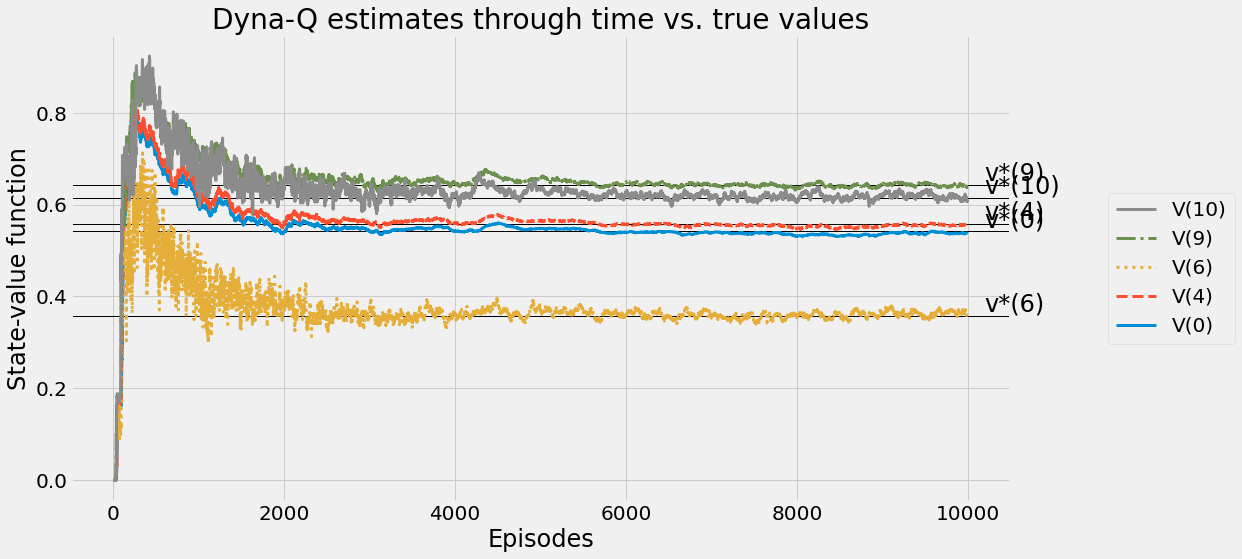

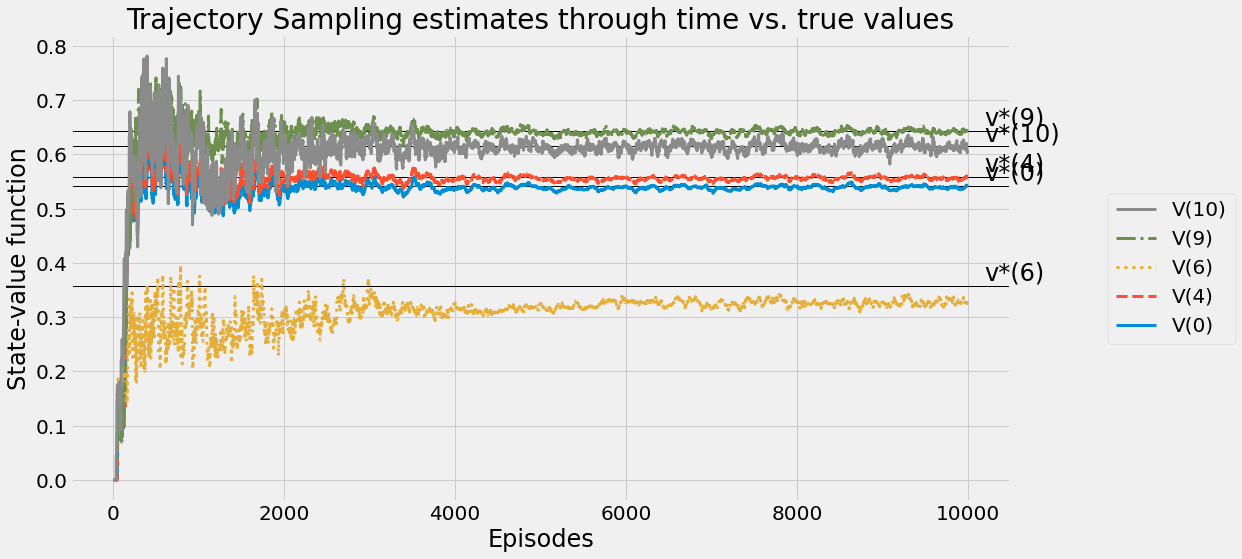

In [74]:
plot_value_function(
    'Sarsa(λ) replacing estimates through time vs. true values', 
    np.max(Q_track_rsl, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Sarsa(λ) accumulating estimates through time vs. true values', 
    np.max(Q_track_asl, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Q(λ) replacing estimates through time vs. true values', 
    np.max(Q_track_rqll, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Q(λ) accumulating estimates through time vs. true values', 
    np.max(Q_track_aqll, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)
plot_value_function(
    'Trajectory Sampling estimates through time vs. true values', 
    np.max(Q_track_ts, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)